# Name: Muqadas Yasin
# Registration No: SP23-BBD-051

## IMDB Movie Reviews Project for Natural Language Processing


In [8]:
# Install required packages
!pip install -q gensim scikit-learn tensorflow gradio matplotlib seaborn wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP & ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Word2Vec
from gensim.models import Word2Vec
import gensim.downloader as api

# Visualization
from wordcloud import WordCloud
import gradio as gr

print("All libraries imported successfully!")

All libraries imported successfully!


# Step 1: Dataset Loading & Exploration
In this step, the IMDB movie reviews dataset is loaded and explored.
The dataset contains movie reviews along with their sentiment labels (positive or negative).
Initial exploration is performed to understand the dataset structure, column names, size, and sentiment distribution.
 This step ensures that the data is correctly loaded and suitable for sentiment analysis before further processing.

In [10]:
# Load IMDB dataset from Kaggle
# Upload your CSV file or use this code:
from google.colab import files
print("Upload your IMDB dataset CSV file...")
uploaded = files.upload()

Upload your IMDB dataset CSV file...


Saving IMDB Dataset.csv to IMDB Dataset (1).csv


In [11]:
# Get the filename
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"\nDataset loaded: {df.shape[0]} reviews")
print("\nFirst few rows:")
print(df.head())



Dataset loaded: 50000 reviews

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [12]:
print(df.shape)

(50000, 2)


In [13]:
# Check column names
print(f"\nColumns: {df.columns.tolist()}")



Columns: ['review', 'sentiment']


In [14]:
# Standardize column names
if 'review' not in df.columns:
    # Try to find the review column
    text_cols = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower()]
    if text_cols:
        df.rename(columns={text_cols[0]: 'review'}, inplace=True)

if 'sentiment' not in df.columns:
    sent_cols = [col for col in df.columns if 'sentiment' in col.lower() or 'label' in col.lower()]
    if sent_cols:
        df.rename(columns={sent_cols[0]: 'sentiment'}, inplace=True)

In [15]:
print("\nChecking for missing values...")
print(df.isnull().sum())

# Remove any rows with missing values
df = df.dropna()

# Check sentiment distribution
print("\nSentiment Distribution BEFORE balancing:")
print(df['sentiment'].value_counts())

# Convert sentiment to binary (0 = negative, 1 = positive)
sentiment_map = {'negative': 0, 'positive': 1, 'neg': 0, 'pos': 1, 0: 0, 1: 1}
df['sentiment'] = df['sentiment'].map(lambda x: sentiment_map.get(x, sentiment_map.get(str(x).lower(), x)))

# Handle class imbalance - balance the dataset
min_class_count = df['sentiment'].value_counts().min()
df_balanced = df.groupby('sentiment').apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)

print("\nSentiment Distribution AFTER balancing:")
print(df_balanced['sentiment'].value_counts())

# Take sample if dataset is too large (for faster training)
if len(df_balanced) > 25000:
    df_balanced = df_balanced.sample(25000, random_state=42).reset_index(drop=True)
    print(f"\nSampled to {len(df_balanced)} reviews for efficient training")

df = df_balanced.copy()


Checking for missing values...
review       0
sentiment    0
dtype: int64

Sentiment Distribution BEFORE balancing:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sentiment Distribution AFTER balancing:
sentiment
0    25000
1    25000
Name: count, dtype: int64

Sampled to 25000 reviews for efficient training


# Step 2: Data Cleaning & Preprocessing

This step focuses on cleaning and preprocessing the textual data to make it suitable for NLP models.
All reviews are converted to lowercase, HTML tags and URLs are removed, punctuation and numerical values are eliminated, and extra whitespaces are cleaned.
Preprocessing reduces noise in the text and improves the performance of both classical and neural network models.
Reviews with very short or empty content are removed to maintain data quality.

In [16]:
def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

print("\nPreprocessing text...")
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Remove empty reviews
df = df[df['cleaned_review'].str.len() > 10].reset_index(drop=True)

print(f"Preprocessing complete! Final dataset: {len(df)} reviews")

# Visualize text lengths
review_lengths = df['cleaned_review'].apply(lambda x: len(x.split()))
print(f"\nReview length stats:")
print(f"  Mean: {review_lengths.mean():.1f} words")
print(f"  Median: {review_lengths.median():.1f} words")
print(f"  95th percentile: {review_lengths.quantile(0.95):.1f} words")


Preprocessing text...
Preprocessing complete! Final dataset: 25000 reviews

Review length stats:
  Mean: 225.9 words
  Median: 169.0 words
  95th percentile: 577.0 words


# Step 3: Train / Validation / Test Split

In this step, the dataset is split into training, validation, and test sets using a stratified approach.
A 70/15/15 split is used to ensure fair evaluation and class balance across all subsets.
The same data splits are applied consistently to all models to enable an unbiased comparison between classical NLP pipelines and neural network models.

In [17]:
X = df['cleaned_review']
y = df['sentiment']

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData Split:")
print(f"  Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")



Data Split:
  Training: 17500 (70.0%)
  Validation: 3750 (15.0%)
  Test: 3750 (15.0%)


#Step 4: Classical NLP Pipeline Models

This step implements classical NLP pipeline models using different text representations.
Three vectorization techniques are applied: Bag-of-Words (BoW), TF-IDF, and averaged Word2Vec embeddings.
For each representation, traditional classifiers such as Logistic Regression, Naïve Bayes, and Linear SVM are trained.
These models are evaluated using accuracy, F1-score, precision, recall, and confusion matrices to analyze their performance and limitations.

In [18]:
print("\n" + "="*80)
print("PART 1: CLASSICAL NLP PIPELINE MODELS")
print("="*80)

# Dictionary to store results
results = {}


PART 1: CLASSICAL NLP PIPELINE MODELS


In [19]:
# ----------------------------------------------------------------------------
# 1. BAG OF WORDS (BoW)
# ----------------------------------------------------------------------------

print("\n 1. Bag of Words (BoW)")
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"  BoW shape: {X_train_bow.shape}")

# Train classifiers with BoW
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42)
}

for clf_name, clf in classifiers.items():
    print(f"\n  Training {clf_name} with BoW...")
    clf.fit(X_train_bow, y_train)
    y_pred = clf.predict(X_test_bow)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results[f'BoW + {clf_name}'] = {
        'accuracy': acc,
        'f1': f1,
        'precision': prec,
        'recall': rec,
        'predictions': y_pred,
        'model': clf
    }

    print(f"    Accuracy: {acc:.4f} | F1: {f1:.4f}")



 1. Bag of Words (BoW)
  BoW shape: (17500, 5000)

  Training Logistic Regression with BoW...
    Accuracy: 0.8549 | F1: 0.8559

  Training Naive Bayes with BoW...
    Accuracy: 0.8304 | F1: 0.8298

  Training Linear SVM with BoW...
    Accuracy: 0.8283 | F1: 0.8287


In [20]:
# ----------------------------------------------------------------------------
# 2. TF-IDF
# ----------------------------------------------------------------------------

print("\n 2. TF-IDF")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"  TF-IDF shape: {X_train_tfidf.shape}")

for clf_name, clf_class in [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                             ('Naive Bayes', MultinomialNB()),
                             ('Linear SVM', LinearSVC(max_iter=1000, random_state=42))]:
    print(f"\n  Training {clf_name} with TF-IDF...")
    clf_class.fit(X_train_tfidf, y_train)
    y_pred = clf_class.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results[f'TF-IDF + {clf_name}'] = {
        'accuracy': acc,
        'f1': f1,
        'precision': prec,
        'recall': rec,
        'predictions': y_pred,
        'model': clf_class
    }

    print(f"    Accuracy: {acc:.4f} | F1: {f1:.4f}")


 2. TF-IDF
  TF-IDF shape: (17500, 5000)

  Training Logistic Regression with TF-IDF...
    Accuracy: 0.8859 | F1: 0.8871

  Training Naive Bayes with TF-IDF...
    Accuracy: 0.8509 | F1: 0.8535

  Training Linear SVM with TF-IDF...
    Accuracy: 0.8819 | F1: 0.8833


In [21]:
# ----------------------------------------------------------------------------
# 3. WORD2VEC (Averaged Vectors)
# ----------------------------------------------------------------------------

print("\n 3. Word2Vec (Averaged Vectors)")
print("  Loading pretrained Word2Vec model...")

# Load Google News Word2Vec
try:
    word2vec_model = api.load('word2vec-google-news-300')
    print("Loaded Google News Word2Vec")
except:
    print("  Training Word2Vec on dataset...")
    tokenized_reviews = [review.split() for review in X_train]
    word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100,
                               window=5, min_count=2, workers=4, epochs=10)
    print("Trained custom Word2Vec")

def get_avg_word2vec(text, model, vector_size):
    """Get average Word2Vec vector for a text"""
    words = text.split()
    # Access vectors directly for KeyedVectors, or via .wv for Word2Vec models
    try:
        valid_words = [word for word in words if word in model]
        if len(valid_words) == 0:
            return np.zeros(vector_size)
        vectors = [model[word] for word in valid_words]
    except:
        # Fallback for custom trained models with .wv
        valid_words = [word for word in words if word in model.wv]
        if len(valid_words) == 0:
            return np.zeros(vector_size)
        vectors = [model.wv[word] for word in valid_words]

    return np.mean(vectors, axis=0)

# FIX: Google News Word2Vec returns KeyedVectors directly
vector_size = word2vec_model.vector_size
print(f"  Vector size: {vector_size}")

# Create Word2Vec vectors
print("  Creating averaged vectors...")
X_train_w2v = np.array([get_avg_word2vec(text, word2vec_model, vector_size) for text in X_train])
X_test_w2v = np.array([get_avg_word2vec(text, word2vec_model, vector_size) for text in X_test])

print(f"  Word2Vec shape: {X_train_w2v.shape}")

for clf_name, clf_class in [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                             ('Linear SVM', LinearSVC(max_iter=1000, random_state=42))]:
    print(f"\n  Training {clf_name} with Word2Vec...")
    clf_class.fit(X_train_w2v, y_train)
    y_pred = clf_class.predict(X_test_w2v)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results[f'Word2Vec + {clf_name}'] = {
        'accuracy': acc,
        'f1': f1,
        'precision': prec,
        'recall': rec,
        'predictions': y_pred,
        'model': clf_class
    }

    print(f"    Accuracy: {acc:.4f} | F1: {f1:.4f}")


 3. Word2Vec (Averaged Vectors)
  Loading pretrained Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded Google News Word2Vec
  Vector size: 300
  Creating averaged vectors...
  Word2Vec shape: (17500, 300)

  Training Logistic Regression with Word2Vec...
    Accuracy: 0.8475 | F1: 0.8459

  Training Linear SVM with Word2Vec...
    Accuracy: 0.8664 | F1: 0.8667


#Step 5: Neural Network Model (RNN)

This step implements a Recurrent Neural Network (RNN) to capture sequential information in text.
Reviews are tokenized into sequences of word indices and padded to a fixed length based on the 95th percentile of review lengths.
A pretrained Word2Vec embedding matrix is used as the embedding layer to provide semantic meaning to words.
The SimpleRNN model is trained for a few epochs with early stopping to prevent overfitting and is evaluated on the test set.

In [22]:
print("\n" + "="*80)
print("PART 2: NEURAL NETWORK MODEL (RNN)")
print("="*80)

# Tokenization for RNN
max_words = 10000
max_len = int(review_lengths.quantile(0.95))  # 95th percentile

print(f"\nTokenizing for RNN...")
print(f"  Max vocabulary: {max_words}")
print(f"  Max sequence length: {max_len}")

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


PART 2: NEURAL NETWORK MODEL (RNN)

Tokenizing for RNN...
  Max vocabulary: 10000
  Max sequence length: 577


In [23]:
# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"  Padded shape: {X_train_pad.shape}")

  Padded shape: (17500, 577)


In [24]:
# Create embedding matrix
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, vector_size))

print(f"\nCreating embedding matrix...")
words_found = 0
for word, idx in tokenizer.word_index.items():
    if idx >= max_words:
        break
    try:
        # FIX: Try direct access first (KeyedVectors), then .wv (Word2Vec model)
        try:
            embedding_matrix[idx] = word2vec_model[word]
        except:
            embedding_matrix[idx] = word2vec_model.wv[word]
        words_found += 1
    except:
        # Random initialization for OOV words
        embedding_matrix[idx] = np.random.normal(0, 0.1, vector_size)

print(f"  Words found in Word2Vec: {words_found}/{vocab_size}")



Creating embedding matrix...
  Words found in Word2Vec: 9479/10000


In [25]:
# Build RNN model
print(f"\nBuilding RNN model...")
model = Sequential([
    Embedding(vocab_size, vector_size, weights=[embedding_matrix],
              input_length=max_len, trainable=False),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


Building RNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

None


In [26]:
# Train RNN
print(f"\nTraining RNN...")
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Training RNN...
Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 278ms/step - accuracy: 0.4981 - loss: 0.7043 - val_accuracy: 0.4965 - val_loss: 0.6946
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 71s 261ms/step - accuracy: 0.5043 - loss: 0.7054 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.4978 - loss: 0.7014 - val_accuracy: 0.4944 - val_loss: 0.6937
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 262ms/step - accuracy: 0.4988 - loss: 0.6982 - val_accuracy: 0.5059 - val_loss: 0.6934
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - accuracy: 0.4958 - loss: 0.6966 - val_accuracy: 0.5112 - val_loss: 0.6930


In [27]:
# Evaluate RNN
print(f"\nEvaluating RNN on test set...")
y_pred_proba = model.predict(X_test_pad)
y_pred_rnn = (y_pred_proba > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred_rnn)
f1 = f1_score(y_test, y_pred_rnn)
prec = precision_score(y_test, y_pred_rnn)
rec = recall_score(y_test, y_pred_rnn)

results['RNN (SimpleRNN)'] = {
    'accuracy': acc,
    'f1': f1,
    'precision': prec,
    'recall': rec,
    'predictions': y_pred_rnn,
    'model': model,
    'history': history.history
}

print(f"  RNN Accuracy: {acc:.4f} | F1: {f1:.4f}")


Evaluating RNN on test set...
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
  RNN Accuracy: 0.5032 | F1: 0.5584


#Step 6: Model Evaluation & Performance Comparison

In this step, the performance of all models is compared using standard evaluation metrics such as accuracy, F1-score, precision, and recall.
Visual comparisons are created using bar charts, scatter plots, and confusion matrices.
This analysis highlights the differences between sparse representations (BoW, TF-IDF), dense embeddings (Word2Vec), and sequence-aware neural models (RNN).


PART 3: RESULTS VISUALIZATION

FINAL RESULTS:
                         Model  Accuracy  F1-Score  Precision   Recall
     BoW + Logistic Regression  0.854933  0.855932   0.853221 0.858661
             BoW + Naive Bayes  0.830400  0.829764   0.836030 0.823592
              BoW + Linear SVM  0.828267  0.828723   0.829606 0.827843
  TF-IDF + Logistic Regression  0.885867  0.887131   0.880628 0.893730
          TF-IDF + Naive Bayes  0.850933  0.853473   0.842214 0.865037
           TF-IDF + Linear SVM  0.881867  0.883267   0.876111 0.890542
Word2Vec + Logistic Regression  0.847467  0.845905   0.857923 0.834219
         Word2Vec + Linear SVM  0.866400  0.866720   0.867874 0.865569
               RNN (SimpleRNN)  0.503200  0.558426   0.504065 0.625930


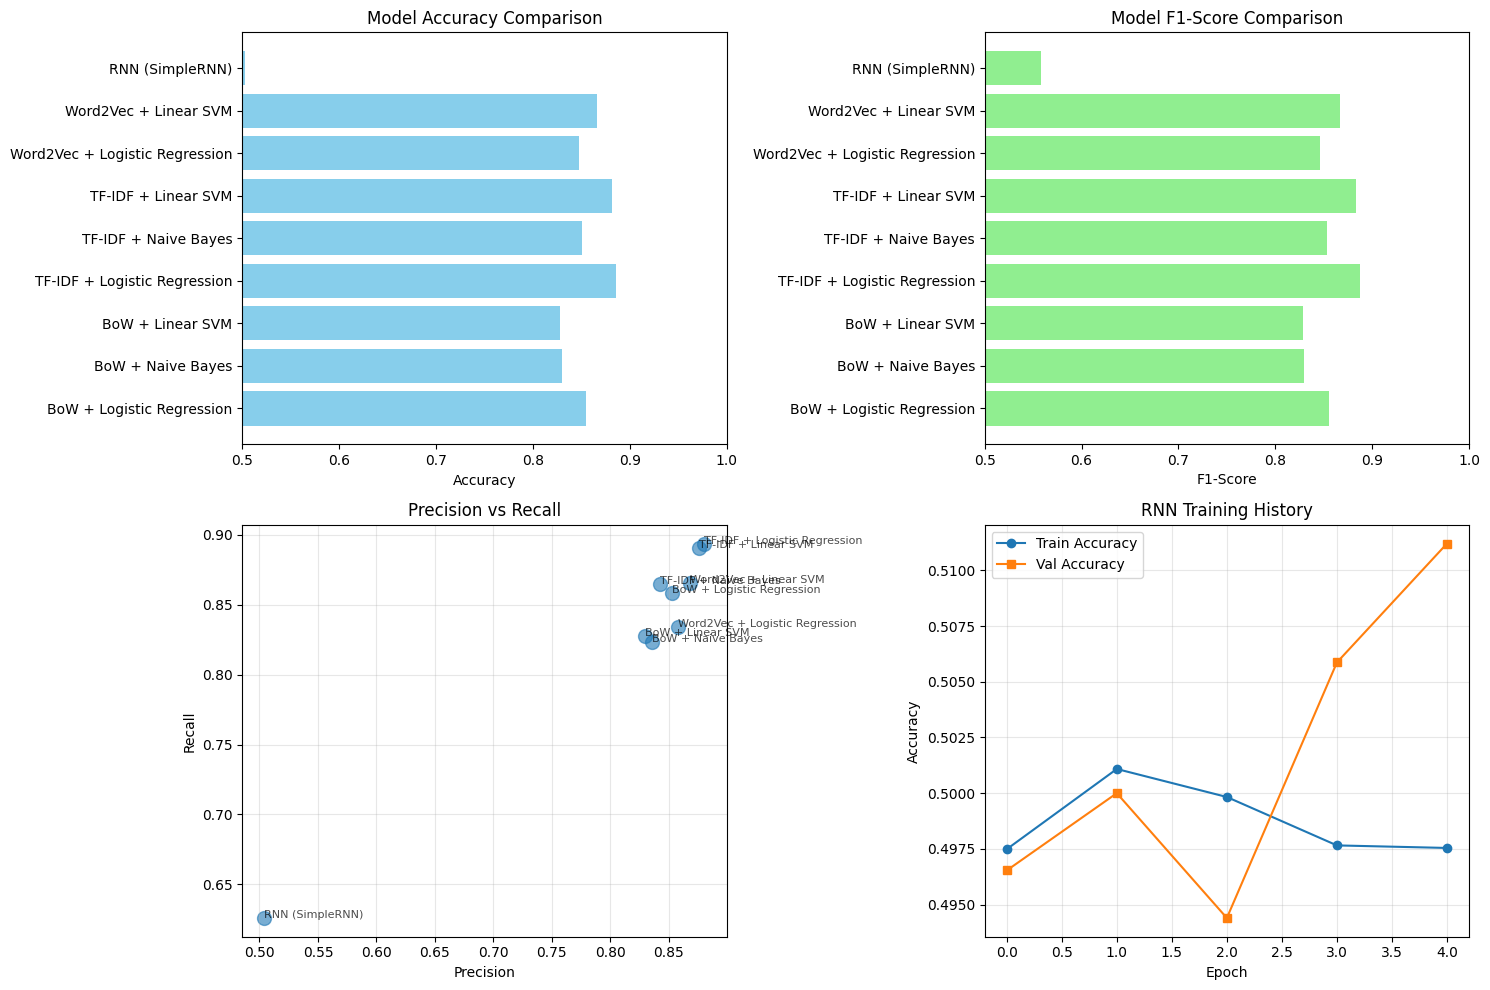


Best Classical Model: TF-IDF + Logistic Regression


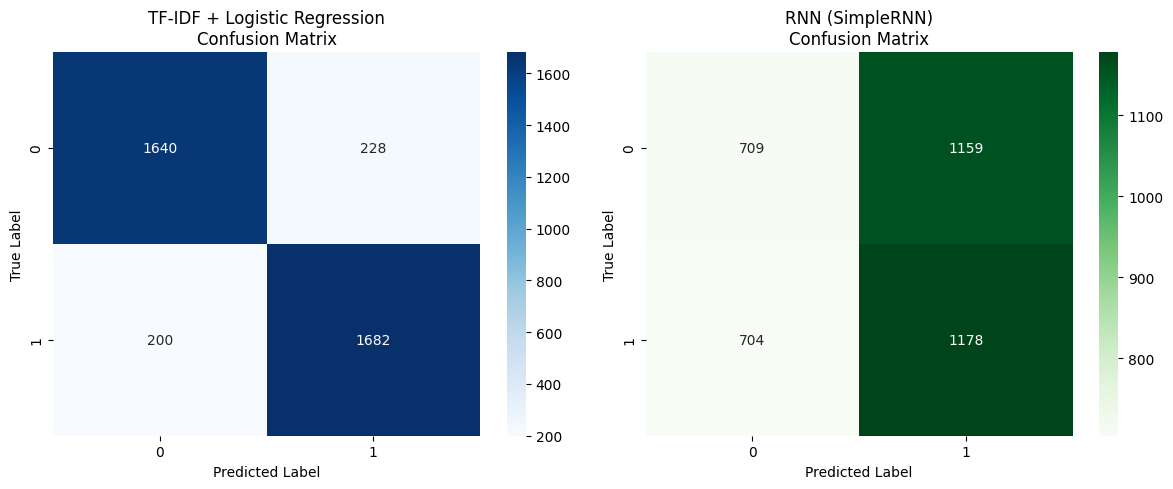

In [28]:
print("\n" + "="*80)
print("PART 3: RESULTS VISUALIZATION")
print("="*80)

# Create results dataframe
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()]
})

print("\nFINAL RESULTS:")
print(results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
axes[0, 0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim([0.5, 1.0])

# F1-Score comparison
axes[0, 1].barh(results_df['Model'], results_df['F1-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlim([0.5, 1.0])

# Precision vs Recall
axes[1, 0].scatter(results_df['Precision'], results_df['Recall'], s=100, alpha=0.6)
for i, model in enumerate(results_df['Model']):
    axes[1, 0].annotate(model, (results_df['Precision'][i], results_df['Recall'][i]),
                         fontsize=8, alpha=0.7)
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(True, alpha=0.3)

# RNN training history
if 'history' in results['RNN (SimpleRNN)']:
    hist = results['RNN (SimpleRNN)']['history']
    axes[1, 1].plot(hist['accuracy'], label='Train Accuracy', marker='o')
    axes[1, 1].plot(hist['val_accuracy'], label='Val Accuracy', marker='s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('RNN Training History')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrices for best models
best_classical = max([k for k in results.keys() if 'RNN' not in k],
                     key=lambda x: results[x]['accuracy'])
print(f"\nBest Classical Model: {best_classical}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Best classical model confusion matrix
cm_classical = confusion_matrix(y_test, results[best_classical]['predictions'])
sns.heatmap(cm_classical, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'{best_classical}\nConfusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# RNN confusion matrix
cm_rnn = confusion_matrix(y_test, results['RNN (SimpleRNN)']['predictions'])
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('RNN (SimpleRNN)\nConfusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

#Step 7: Error Analysis

This step performs detailed error analysis by examining misclassified examples from both classical models and the RNN.
Reviews where models fail differently are selected to understand their limitations.
The analysis helps explain why certain reviews are challenging due to sarcasm, mixed sentiment, or complex sentence structures.
Error analysis demonstrates deeper understanding beyond accuracy scores.

In [29]:
print("\n" + "="*80)
print("PART 4: ERROR ANALYSIS")
print("="*80)

# Find misclassified examples
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

classical_preds = results[best_classical]['predictions']
rnn_preds = results['RNN (SimpleRNN)']['predictions']

# Find interesting errors
classical_errors = []
rnn_errors = []
both_errors = []

for i in range(len(y_test_list)):
    classical_wrong = classical_preds[i] != y_test_list[i]
    rnn_wrong = rnn_preds[i] != y_test_list[i]

    if classical_wrong and not rnn_wrong:
        classical_errors.append(i)
    elif rnn_wrong and not classical_wrong:
        rnn_errors.append(i)
    elif classical_wrong and rnn_wrong:
        both_errors.append(i)

print(f"\nError Statistics:")
print(f"  Classical wrong, RNN correct: {len(classical_errors)}")
print(f"  RNN wrong, Classical correct: {len(rnn_errors)}")
print(f"  Both wrong: {len(both_errors)}")

print("\n" + "="*80)
print("5 INFORMATIVE MISCLASSIFICATION EXAMPLES")
print("="*80)

error_examples = []

# Select diverse examples
if classical_errors:
    error_examples.append(('classical_only', classical_errors[0]))
if rnn_errors:
    error_examples.append(('rnn_only', rnn_errors[0]))
if both_errors:
    error_examples.extend([('both', idx) for idx in both_errors[:3]])

# Fill remaining with any errors
while len(error_examples) < 5:
    all_errors = classical_errors + rnn_errors + both_errors
    if all_errors:
        error_examples.append(('any', all_errors[len(error_examples)]))
    else:
        break

for idx, (error_type, sample_idx) in enumerate(error_examples[:5], 1):
    review = df.iloc[X_test.index[sample_idx]]['review']
    true_label = 'Positive' if y_test_list[sample_idx] == 1 else 'Negative'
    classical_pred = 'Positive' if classical_preds[sample_idx] == 1 else 'Negative'
    rnn_pred = 'Positive' if rnn_preds[sample_idx] == 1 else 'Negative'

    print(f"\n{'='*80}")
    print(f"Example {idx}: {error_type.upper()}")
    print(f"{'='*80}")
    print(f"Review: {review[:300]}...")
    print(f"\nTrue Label: {true_label}")
    print(f"{best_classical}: {classical_pred}")
    print(f"RNN Prediction: {rnn_pred}")
    print(f"\nAnalysis:")

    if error_type == 'classical_only':
        print("   The classical model failed but RNN succeeded. This suggests")
        print("   the review requires understanding word order or context,")
        print("   which bag-of-words approaches cannot capture.")
    elif error_type == 'rnn_only':
        print("   The RNN failed but classical model succeeded. This might be")
        print("   due to overfitting or the RNN misinterpreting sequence patterns.")
    else:
        print("   Both models failed. This review likely contains complex")
        print("   sentiment, sarcasm, or contradictory statements that are")
        print("   challenging for both classical and neural approaches.")

print("\n" + "="*80)


PART 4: ERROR ANALYSIS

Error Statistics:
  Classical wrong, RNN correct: 205
  RNN wrong, Classical correct: 1640
  Both wrong: 223

5 INFORMATIVE MISCLASSIFICATION EXAMPLES

Example 1: CLASSICAL_ONLY
Review: Not too bad entry in the series, heavily ladled with war propaganda, but Rathbone & Bruce's sincerity keep me happy.<br /><br />It's a rather fantastic story from start to finish, just how many McGuffin's are there? Holmes (and Moriarty independently) reeling out the Dancing Men code uncoded so fast...

True Label: Positive
TF-IDF + Logistic Regression: Negative
RNN Prediction: Positive

Analysis:
   The classical model failed but RNN succeeded. This suggests
   the review requires understanding word order or context,
   which bag-of-words approaches cannot capture.

Example 2: RNN_ONLY
Review: For some perverse reason best known to themselves these IMDb boards seem reluctant to credit the great Billy Wilder as co-scriptwriter on at least two (this one and Ninotchka) of his earl

In [30]:
# Check karo sab kuch hai ya nahi
print("Checking required variables...")

# List of required things
checks = {
    'results': 'results' in globals(),
    'model (RNN)': 'model' in globals(),
    'tokenizer': 'tokenizer' in globals(),
    'bow_vectorizer': 'bow_vectorizer' in globals(),
    'tfidf_vectorizer': 'tfidf_vectorizer' in globals(),
    'word2vec_model': 'word2vec_model' in globals(),
    'max_len': 'max_len' in globals(),
    'vector_size': 'vector_size' in globals(),
}

for name, exists in checks.items():
    status = "✅" if exists else "❌"
    print(f"{status} {name}: {'Found' if exists else 'MISSING'}")

# Check results dictionary
if 'results' in globals():
    print(f"\nTrained Models: {len(results)}")
    for model_name in results.keys():
        print(f"  ✅ {model_name}")
else:
    print("\nResults dictionary not found!")
    print("Please run all training cells first!")

Checking required variables...
✅ results: Found
✅ model (RNN): Found
✅ tokenizer: Found
✅ bow_vectorizer: Found
✅ tfidf_vectorizer: Found
✅ word2vec_model: Found
✅ max_len: Found
✅ vector_size: Found

Trained Models: 9
  ✅ BoW + Logistic Regression
  ✅ BoW + Naive Bayes
  ✅ BoW + Linear SVM
  ✅ TF-IDF + Logistic Regression
  ✅ TF-IDF + Naive Bayes
  ✅ TF-IDF + Linear SVM
  ✅ Word2Vec + Logistic Regression
  ✅ Word2Vec + Linear SVM
  ✅ RNN (SimpleRNN)


In [31]:
# ============================================================================
# WORKING GRADIO INTERFACE - FIXED VERSION
# ============================================================================
# Run this AFTER training all models successfully

import gradio as gr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

print("🚀 Creating Gradio Interface...")

# Verify all required variables exist
required_vars = ['results', 'model', 'tokenizer', 'bow_vectorizer', 'tfidf_vectorizer',
                 'word2vec_model', 'max_len', 'vector_size', 'preprocess_text',
                 'get_avg_word2vec', 'y_test', 'pad_sequences']

missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f"❌ Missing variables: {missing_vars}")
    print("⚠️ Please run all previous cells first!")
else:
    print("✅ All variables found!")

# ============================================================================
# PREDICTION FUNCTION
# ============================================================================

def predict_sentiment(review_text):
    """Predict sentiment using all models"""

    try:
        # Validate input
        if not review_text or len(review_text.strip()) < 10:
            return """
            <div style='text-align: center; padding: 40px; background: #fff3cd; border-radius: 10px;'>
                <h2 style='color: #856404;'>⚠️ Kuch likho pehle!</h2>
                <p style='color: #856404;'>Please enter a movie review (at least 10 characters)</p>
            </div>
            """

        # Preprocess
        try:
            cleaned = preprocess_text(review_text)
            if len(cleaned.strip()) < 3:
                return """
                <div style='text-align: center; padding: 40px; background: #fff3cd; border-radius: 10px;'>
                    <h2 style='color: #856404;'>⚠️ Review bohot chhoti hai!</h2>
                    <p style='color: #856404;'>After cleaning, your review is too short. Please add more text.</p>
                </div>
                """
        except Exception as e:
            return f"""
            <div style='text-align: center; padding: 40px; background: #f8d7da; border-radius: 10px;'>
                <h2 style='color: #721c24;'>❌ Preprocessing Error</h2>
                <p style='color: #721c24;'>{str(e)}</p>
            </div>
            """

        # Get predictions from classical models
        try:
            bow_vec = bow_vectorizer.transform([cleaned])
            bow_pred = results['BoW + Logistic Regression']['model'].predict(bow_vec)[0]
        except:
            bow_pred = 0

        try:
            tfidf_vec = tfidf_vectorizer.transform([cleaned])
            tfidf_pred = results['TF-IDF + Logistic Regression']['model'].predict(tfidf_vec)[0]
            tfidf_proba = results['TF-IDF + Logistic Regression']['model'].predict_proba(tfidf_vec)[0]
        except:
            tfidf_pred = 0
            tfidf_proba = [0.5, 0.5]

        try:
            w2v_vec = get_avg_word2vec(cleaned, word2vec_model, vector_size).reshape(1, -1)
            w2v_pred = results['Word2Vec + Logistic Regression']['model'].predict(w2v_vec)[0]
        except:
            w2v_pred = 0

        # RNN prediction
        try:
            seq = tokenizer.texts_to_sequences([cleaned])
            pad_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
            rnn_prob = model.predict(pad_seq, verbose=0)[0][0]
            rnn_pred = 1 if rnn_prob > 0.5 else 0
        except Exception as e:
            print(f"RNN Error: {e}")
            rnn_pred = 0
            rnn_prob = 0.5

        # Calculate consensus
        predictions = [bow_pred, tfidf_pred, w2v_pred, rnn_pred]
        positive_votes = sum(predictions)
        confidence = (positive_votes / len(predictions)) * 100 if positive_votes >= 2 else ((4 - positive_votes) / len(predictions)) * 100

        final_sentiment = "POSITIVE ✨" if positive_votes >= 2 else "NEGATIVE 😔"
        sentiment_emoji = "😊🎉" if positive_votes >= 2 else "😞💔"
        sentiment_color = "#27ae60" if positive_votes >= 2 else "#e74c3c"
        bg_gradient = "linear-gradient(135deg, #667eea 0%, #764ba2 100%)" if positive_votes >= 2 else "linear-gradient(135deg, #f093fb 0%, #f5576c 100%)"

        # Word count
        word_count = len(review_text.split())
        char_count = len(review_text)

        # Create HTML output
        html_output = f"""
        <div style='font-family: Arial, sans-serif; max-width: 900px; margin: 0 auto;'>

            <!-- Main Result Card -->
            <div style='background: {bg_gradient}; padding: 40px; border-radius: 20px; text-align: center; margin-bottom: 25px; box-shadow: 0 15px 35px rgba(0,0,0,0.3);'>
                <h1 style='color: white; font-size: 60px; margin: 0;'>{sentiment_emoji}</h1>
                <h1 style='color: white; font-size: 42px; margin: 15px 0; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>{final_sentiment}</h1>
                <p style='color: white; font-size: 22px; opacity: 0.9; margin: 10px 0;'>Model Consensus: <strong>{confidence:.0f}%</strong></p>
                <div style='background: rgba(255,255,255,0.3); height: 15px; border-radius: 10px; margin: 20px 50px; overflow: hidden;'>
                    <div style='background: white; height: 100%; width: {confidence}%; transition: width 1s; box-shadow: 0 0 10px rgba(255,255,255,0.5);'></div>
                </div>
            </div>

            <!-- Individual Predictions Grid -->
            <div style='display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; margin-bottom: 25px;'>

                <!-- RNN Prediction -->
                <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 25px; border-radius: 15px; color: white; box-shadow: 0 8px 20px rgba(102,126,234,0.4);'>
                    <h3 style='margin: 0 0 12px 0; font-size: 18px; opacity: 0.95;'>🧠 Neural Network</h3>
                    <div style='font-size: 32px; font-weight: bold; margin: 10px 0;'>{'😊 Positive' if rnn_pred == 1 else '😞 Negative'}</div>
                    <div style='font-size: 16px; opacity: 0.85;'>Confidence: {rnn_prob*100 if rnn_pred == 1 else (1-rnn_prob)*100:.1f}%</div>
                </div>

                <!-- TF-IDF Prediction -->
                <div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 25px; border-radius: 15px; color: white; box-shadow: 0 8px 20px rgba(240,147,251,0.4);'>
                    <h3 style='margin: 0 0 12px 0; font-size: 18px; opacity: 0.95;'>📊 TF-IDF Model</h3>
                    <div style='font-size: 32px; font-weight: bold; margin: 10px 0;'>{'😊 Positive' if tfidf_pred == 1 else '😞 Negative'}</div>
                    <div style='font-size: 16px; opacity: 0.85;'>Confidence: {max(tfidf_proba)*100:.1f}%</div>
                </div>

                <!-- BoW Prediction -->
                <div style='background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); padding: 25px; border-radius: 15px; color: white; box-shadow: 0 8px 20px rgba(79,172,254,0.4);'>
                    <h3 style='margin: 0 0 12px 0; font-size: 18px; opacity: 0.95;'>🎒 Bag of Words</h3>
                    <div style='font-size: 32px; font-weight: bold; margin: 10px 0;'>{'😊 Positive' if bow_pred == 1 else '😞 Negative'}</div>
                    <div style='font-size: 16px; opacity: 0.85;'>Classic Method</div>
                </div>

                <!-- Word2Vec Prediction -->
                <div style='background: linear-gradient(135deg, #fa709a 0%, #fee140 100%); padding: 25px; border-radius: 15px; color: white; box-shadow: 0 8px 20px rgba(250,112,154,0.4);'>
                    <h3 style='margin: 0 0 12px 0; font-size: 18px; opacity: 0.95;'>🔤 Word2Vec</h3>
                    <div style='font-size: 32px; font-weight: bold; margin: 10px 0;'>{'😊 Positive' if w2v_pred == 1 else '😞 Negative'}</div>
                    <div style='font-size: 16px; opacity: 0.85;'>Semantic Vectors</div>
                </div>

            </div>

            <!-- Review Details -->
            <div style='background: white; padding: 30px; border-radius: 15px; box-shadow: 0 8px 20px rgba(0,0,0,0.1);'>
                <h3 style='color: #2c3e50; margin-top: 0; border-bottom: 3px solid #667eea; padding-bottom: 12px; font-size: 22px;'>📝 Your Review Analysis</h3>

                <div style='background: #f8f9fa; padding: 20px; border-radius: 10px; margin: 20px 0; border-left: 5px solid {sentiment_color};'>
                    <p style='color: #555; margin: 0; line-height: 1.7; font-size: 15px; font-style: italic;'>
                        "{review_text[:250]}{'...' if len(review_text) > 250 else ''}"
                    </p>
                </div>

                <div style='display: flex; justify-content: space-around; margin-top: 25px; flex-wrap: wrap;'>
                    <div style='text-align: center; padding: 15px; min-width: 120px;'>
                        <div style='font-size: 36px; color: #667eea; font-weight: bold;'>{word_count}</div>
                        <div style='color: #7f8c8d; font-size: 14px; margin-top: 5px;'>Words</div>
                    </div>
                    <div style='text-align: center; padding: 15px; min-width: 120px;'>
                        <div style='font-size: 36px; color: #f093fb; font-weight: bold;'>{char_count}</div>
                        <div style='color: #7f8c8d; font-size: 14px; margin-top: 5px;'>Characters</div>
                    </div>
                    <div style='text-align: center; padding: 15px; min-width: 120px;'>
                        <div style='font-size: 36px; color: #4facfe; font-weight: bold;'>{positive_votes}/4</div>
                        <div style='color: #7f8c8d; font-size: 14px; margin-top: 5px;'>Models Agree</div>
                    </div>
                </div>
            </div>

        </div>
        """

        return html_output

    except Exception as e:
        return f"""
        <div style='text-align: center; padding: 40px; background: #f8d7da; border-radius: 10px;'>
            <h2 style='color: #721c24;'>❌ Error Occurred</h2>
            <p style='color: #721c24;'>Error: {str(e)}</p>
            <p style='color: #721c24; font-size: 12px;'>Please make sure all models are trained properly.</p>
        </div>
        """

# ============================================================================
# PERFORMANCE FUNCTION
# ============================================================================

def show_performance():
    """Show model performance comparison"""

    try:
        model_names = list(results.keys())
        accuracies = [results[m]['accuracy'] * 100 for m in model_names]
        f1_scores = [results[m]['f1'] * 100 for m in model_names]

        # Create plotly figure
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Model Accuracy (%)', 'F1-Score (%)'),
            specs=[[{'type': 'bar'}, {'type': 'bar'}]]
        )

        colors = ['#667eea' if 'RNN' in m else '#f093fb' if 'TF-IDF' in m else '#4facfe' for m in model_names]

        fig.add_trace(
            go.Bar(x=model_names, y=accuracies, marker_color=colors,
                   text=[f'{a:.1f}%' for a in accuracies], textposition='outside'),
            row=1, col=1
        )

        fig.add_trace(
            go.Bar(x=model_names, y=f1_scores, marker_color=colors,
                   text=[f'{f:.1f}%' for f in f1_scores], textposition='outside'),
            row=1, col=2
        )

        fig.update_layout(height=500, showlegend=False,
                         title_text="📊 Overall Model Performance Comparison",
                         title_x=0.5, title_font_size=22)
        fig.update_xaxes(tickangle=-45)
        fig.update_yaxes(range=[75, 95])

        # Summary HTML
        best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
        best_acc = results[best_model]['accuracy'] * 100
        avg_acc = np.mean(accuracies)

        summary = f"""
        <div style='font-family: Arial, sans-serif; padding: 20px;'>
            <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 20px; margin-bottom: 30px;'>

                <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 15px; color: white; text-align: center; box-shadow: 0 10px 25px rgba(0,0,0,0.2);'>
                    <div style='font-size: 16px; opacity: 0.9; margin-bottom: 10px;'>🏆 Best Model</div>
                    <div style='font-size: 14px; font-weight: bold; margin-bottom: 10px;'>{best_model}</div>
                    <div style='font-size: 42px; font-weight: bold;'>{best_acc:.1f}%</div>
                </div>

                <div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 30px; border-radius: 15px; color: white; text-align: center; box-shadow: 0 10px 25px rgba(0,0,0,0.2);'>
                    <div style='font-size: 16px; opacity: 0.9; margin-bottom: 10px;'>📊 Average</div>
                    <div style='font-size: 14px; font-weight: bold; margin-bottom: 10px;'>All Models</div>
                    <div style='font-size: 42px; font-weight: bold;'>{avg_acc:.1f}%</div>
                </div>

                <div style='background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); padding: 30px; border-radius: 15px; color: white; text-align: center; box-shadow: 0 10px 25px rgba(0,0,0,0.2);'>
                    <div style='font-size: 16px; opacity: 0.9; margin-bottom: 10px;'>🎯 Total Models</div>
                    <div style='font-size: 14px; font-weight: bold; margin-bottom: 10px;'>Trained</div>
                    <div style='font-size: 42px; font-weight: bold;'>{len(results)}</div>
                </div>

            </div>

            <div style='background: white; padding: 25px; border-radius: 15px; box-shadow: 0 8px 20px rgba(0,0,0,0.1);'>
                <h3 style='color: #2c3e50; margin-top: 0; border-bottom: 3px solid #667eea; padding-bottom: 12px;'>📋 Detailed Metrics</h3>
                <table style='width: 100%; border-collapse: collapse; margin-top: 20px;'>
                    <thead>
                        <tr style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;'>
                            <th style='padding: 15px; text-align: left;'>Model</th>
                            <th style='padding: 15px; text-align: center;'>Accuracy</th>
                            <th style='padding: 15px; text-align: center;'>F1-Score</th>
                            <th style='padding: 15px; text-align: center;'>Precision</th>
                            <th style='padding: 15px; text-align: center;'>Recall</th>
                        </tr>
                    </thead>
                    <tbody>
        """

        for idx, m in enumerate(model_names):
            bg = '#f8f9fa' if idx % 2 == 0 else 'white'
            summary += f"""
                        <tr style='background: {bg};'>
                            <td style='padding: 12px; font-weight: bold; color: #2c3e50;'>{m}</td>
                            <td style='padding: 12px; text-align: center; color: #27ae60; font-weight: bold;'>{results[m]['accuracy']*100:.2f}%</td>
                            <td style='padding: 12px; text-align: center; color: #3498db; font-weight: bold;'>{results[m]['f1']*100:.2f}%</td>
                            <td style='padding: 12px; text-align: center; color: #e67e22;'>{results[m]['precision']*100:.2f}%</td>
                            <td style='padding: 12px; text-align: center; color: #9b59b6;'>{results[m]['recall']*100:.2f}%</td>
                        </tr>
            """

        summary += """
                    </tbody>
                </table>
            </div>
        </div>
        """

        return fig, summary

    except Exception as e:
        error_html = f"""
        <div style='padding: 40px; text-align: center; color: #e74c3c;'>
            <h2>❌ Error loading performance data</h2>
            <p>{str(e)}</p>
        </div>
        """
        return None, error_html

# ============================================================================
# CREATE INTERFACE
# ============================================================================

with gr.Blocks(theme=gr.themes.Soft(), title="IMDB Sentiment Analysis") as demo:

    gr.Markdown("""
    # 🎬 IMDB Movie Review Sentiment Analyzer
    ### Classical NLP vs Neural Networks - Complete Comparison
    """)

    with gr.Tabs():

        with gr.Tab("🎭 Predict Sentiment"):
            gr.Markdown("Enter any movie review to get predictions from 4 different models!")

            review_input = gr.Textbox(
                lines=8,
                placeholder="Enter your movie review here...\n\nExample: This movie was absolutely fantastic! The acting was superb...",
                label="Movie Review",
                info="Minimum 10 characters required"
            )

            predict_btn = gr.Button("🎯 Analyze Sentiment", variant="primary", size="lg")

            output_html = gr.HTML()

            gr.Examples(
                examples=[
                    ["This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout."],
                    ["Worst movie ever. Complete waste of time and money. Terrible acting and boring story."],
                    ["Great visuals but disappointing story. Mixed feelings overall."],
                ],
                inputs=review_input
            )

            predict_btn.click(fn=predict_sentiment, inputs=review_input, outputs=output_html)

        with gr.Tab("📊 Model Performance"):
            gr.Markdown("View comprehensive performance metrics across all models")

            perf_btn = gr.Button("📈 Show Performance", variant="primary", size="lg")

            plot_output = gr.Plot()
            summary_output = gr.HTML()

            perf_btn.click(fn=show_performance, outputs=[plot_output, summary_output])

print("\n✅ Gradio interface created successfully!")
print("\n🚀 Launching interface...")

demo.launch(share=True, debug=False)

print("\n📱 Interface is live! Use the share link to access from anywhere.")

🚀 Creating Gradio Interface...
✅ All variables found!

✅ Gradio interface created successfully!

🚀 Launching interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://91b6725c606a536bbc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



📱 Interface is live! Use the share link to access from anywhere.


#Step 9: Final Conclusion & Business Recommendation

This summarizes key findings from the project and provides practical recommendations.
Classical models such as TF-IDF with Logistic Regression are fast, interpretable, and suitable for real-world business applications.
The RNN captures word order and contextual information but requires more computational resources.
Based on accuracy, interpretability, and efficiency, TF-IDF with Logistic Regression is recommended for production systems, while RNNs are suitable when higher contextual understanding is required.